<a href="https://colab.research.google.com/github/raym26/code-to-calculate-numerai-mmc-in-r/blob/master/code_nmr_mmc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code to Calculate MMC vs Regular Payouts....in R

This is the R version of this post from master_key here  https://forum.numer.ai/t/code-to-calculate-mmc-vs-regular-payouts/238.  You know, for those that still code in R -- which of course i continue to find very useful.  



In [7]:
install.packages('ghql')  
install.packages('jsonlite')
install.packages('Rnumerai')



Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



[1] TRUE

[1] TRUE

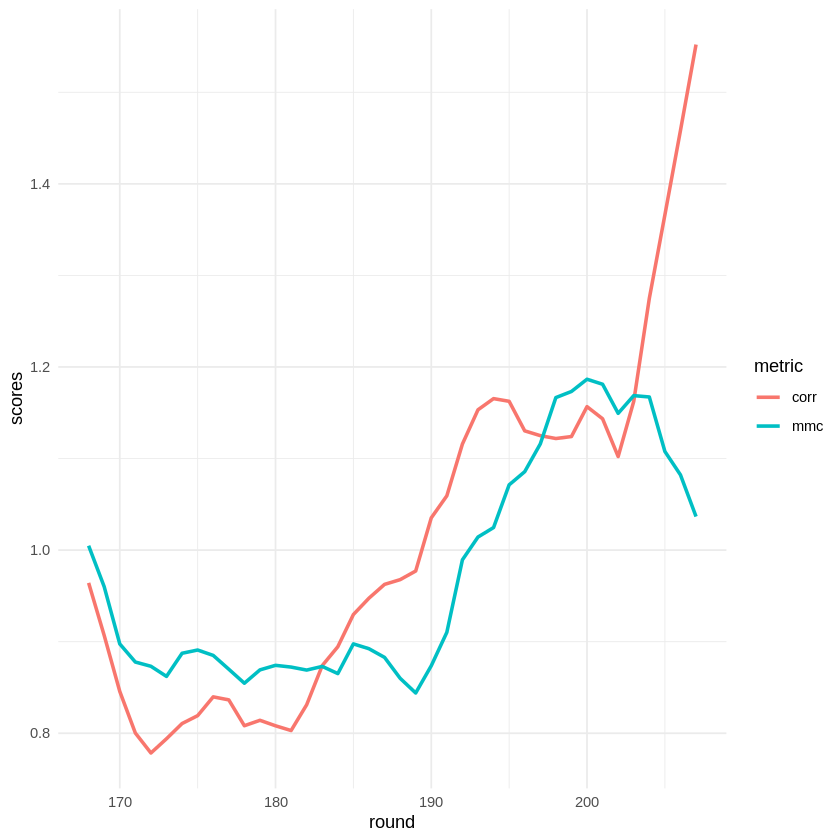

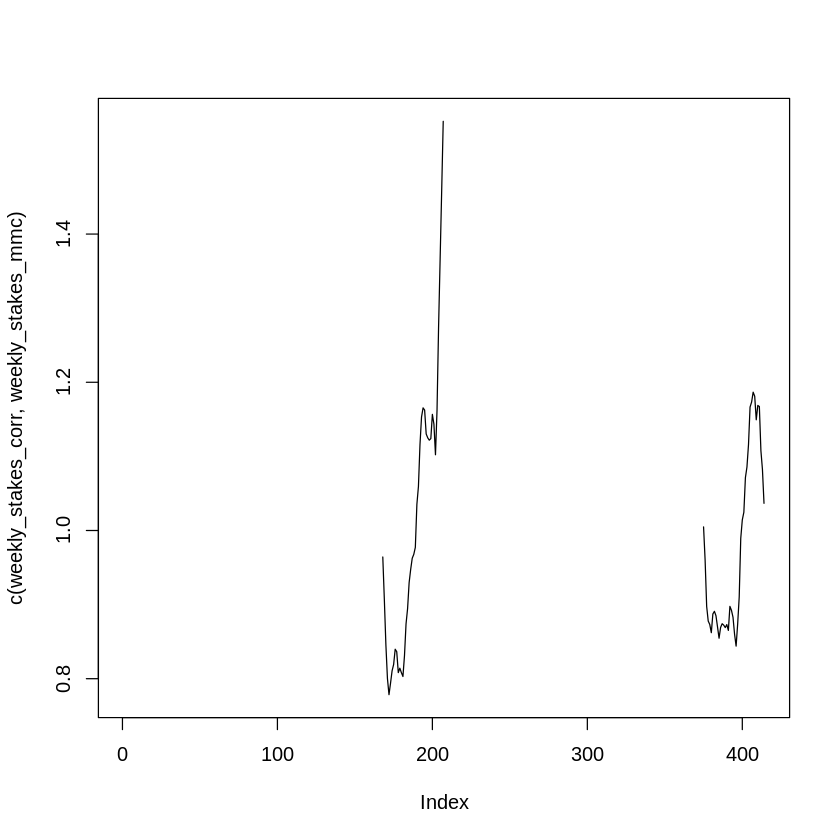

In [9]:
library(ghql) # for querying 
library(jsonlite) # for parsing the json response
#library(httr) # for working with URLs
library(tidyverse) # for tidying data
library(Rnumerai)


set_public_id(<insert_your_id>)
set_api_key(<insert_your_key>)


userPerf <- 'query userperf {v2UserProfile (username: "javibear") {
  dailySubmissionPerformances {
    correlation
    correlationWithMetamodel
    date
    mmc
    roundNumber
  } 
}}'



userperf_list <- run_query(userPerf)
dailyPerf <- do.call(rbind.data.frame, userperf_list$data$v2UserProfile$dailySubmissionPerformances)

#data cleaning
row.names(dailyPerf) <- 1: nrow(dailyPerf)
colnames(dailyPerf)[c(2,5)] <- c("CorrWithMM", "round")

dailyPerf$date <- substr(dailyPerf$date, 1,10) # remove extraneaous characters before converting to date
dailyPerf$date <- as.Date(dailyPerf$date)

dailyPerf_fin <- dailyPerf %>% group_by(round) %>% filter(date == last(date)) %>% arrange(round) %>% as.data.frame()
rownames(dailyPerf_fin) <- dailyPerf_fin$round
dailyPerf_summ <- dailyPerf_fin %>% select(correlation, mmc )

#translating code from https://forum.numer.ai/t/code-to-calculate-mmc-vs-regular-payouts/238

end_round = 207

weekly_stakes_corr = c()
weekly_stakes_mmc = c()
stake_corr = 1 # initial stake
stake_mmc = 1

for (r in 168:end_round) {
  if (as.character(r) %in% rownames(dailyPerf_summ)) {
    corr_score <- dailyPerf_summ[as.character(r), "correlation"]
    mmc_score <- dailyPerf_summ[as.character(r), "mmc"]
  } else {
    corr_score = 0.0
    mmc_score = 0.0
  }
  
  if (corr_score) {
    stake_corr = stake_corr * (1 + corr_score*1)
    stake_mmc = stake_mmc * (1 + mmc_score*2) #2x leverage for mmc
  }
  weekly_stakes_corr[r] = stake_corr
  weekly_stakes_mmc[r] = stake_mmc 
  
   
}

combined <- as.data.frame(cbind(corr=weekly_stakes_corr, mmc=weekly_stakes_mmc))
combined <- combined %>% mutate(round = 1: nrow(combined)) %>% filter(round >=168)
combined <- combined %>% gather('metric', 'scores', -round) %>% arrange(metric)
combined %>% ggplot(aes(round, scores, col = metric))+ geom_line(size = 1) + theme_minimal()
